In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle, randint
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [27]:
df = pd.read_csv('Breast_cancer_data.csv')
print(df.head())
print(df.shape)

   mean_radius  mean_texture  mean_perimeter  mean_area  mean_smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   diagnosis  
0          0  
1          0  
2          0  
3          0  
4          0  
(569, 6)


In [28]:
class GAHyperOpt:
    def __init__(self, features, target, data, params, model, generations, populationSize, mutationPercentage, elites):
        self.X = df[features]
        self.y = df[target]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = 0.3)
        self.model=model
        self.params=params
        self.currPopulation=[]
        self.nextPopulation=[]
        self.generations=generations
        self.accArr=[]
        self.populationSize=populationSize
        self.mutationPercentage=mutationPercentage
        self.elites=elites
    
    def createPopulation(self):
        for childNum in range(self.populationSize):
            myParams={}
            for i in self.params:
                decider=np.random.uniform(0,1)
                paramValue=i[1]+(decider*(i[2]-i[1]))
                if type(i[1])==float:
                    paramValue=round(paramValue, 2)
                elif type(i[1])==int:
                    paramValue=int(paramValue)
                myParams[i[0]]=paramValue
            self.currPopulation.append([myParams,self.fitness(myParams)])
        self.sortCurrPopulation()
#         print("self.currPopulation",self.currPopulation)
        
    def fitness(self,params):
        self.model.set_params(**params)
        self.model.fit(self.X_train, self.y_train)
        self.y_pred=self.model.predict(self.X_test)
        return accuracy_score(self.y_pred, self.y_test)
            
        if forcedMutate:
            decider=1
            probability=0
        else:
            probability=100-self.mutationPercentage
            decider=randint(0,100)
        if decider >= probability:
#             print("mutating!")
            sign=np.random.choice([-1,1])
            pc=randint(0,len(self.params)-1)
            paramchoice=self.params[pc][0]
            currValue=offspring[paramchoice]
            decider2=np.random.uniform(0,1)
            paramValue=(sign*decider2*(self.params[pc][2]-self.params[pc][1]))+currValue
            if type(self.params[pc][1])==float:
                paramValue=min(max(round(paramValue, 2),self.params[pc][1]),self.params[pc][2])
            elif type(self.params[pc][1])==int:
                paramValue=min(max(int(paramValue),self.params[pc][1]),self.params[pc][2])
            offspring[paramchoice]=paramValue
        return offspring
                                        
    def sortCurrPopulation(self):
        self.currPopulation=sorted(self.currPopulation, key=lambda x: x[1], reverse=True)
        
    def sortNextPopulation(self):
        self.nextPopulation=sorted(self.nextPopulation, key=lambda x: x[1], reverse=True)
        
    def elitism(self):
        self.sortCurrPopulation()
        for i in range(self.elites):
            self.nextPopulation.append(self.currPopulation[i][:2].copy())
        
    def makeCrossoverProbabilities(self):
        sum=0
        for child in self.currPopulation:
            sum=sum+child[1]
        multiplier=360/sum
        cumulativeAngle=0
        for child in self.currPopulation:
            child.append(cumulativeAngle)
            cumulativeAngle=(child[1]*multiplier)+cumulativeAngle
            child.append(cumulativeAngle)
    
    def crossover(self):
        if(self.currPopulation[0][0]==self.currPopulation[-1][0]):
            print("Generation converged same hyperparameters")
#             print("Generation converged on following hyperparameters :",self.currPopulation[0][:2])
#             print(self.currPopulation)
            for child in self.currPopulation[self.elites:]:
                mutatedOffspring=self.mutate(child[0],True)
                newChild=[mutatedOffspring,self.fitness(mutatedOffspring)]
                self.nextPopulation.append(newChild)
        else:
            while(len(self.nextPopulation) != self.populationSize):
                decider1=randint(0,360)
                decider2=randint(0,360)
                parent1={}
                parent2={}
                offspring={}
                for child in self.currPopulation:
                    if decider1>child[2] and decider1<=child[3]:
                        parent1=child[0].copy()
                    if decider2>child[2] and decider2<=child[3]:
                        parent2=child[0].copy()
#                 if parent1!=parent2 and parent1!={} and parent2!={}:
                if parent1!={} and parent2!={}:
                    for param in self.params:
                        parentChoice=np.random.choice([1,2])
                        if parentChoice==1:
                            offspring[param[0]]=parent1[param[0]]
                        else:
                            offspring[param[0]]=parent2[param[0]]
                    mutatedOffspring=self.mutate(offspring)
                    newChild=[mutatedOffspring,self.fitness(mutatedOffspring)]
                    self.nextPopulation.append(newChild)
        self.sortNextPopulation()
    
    def plot(self,myArr,metric,scatter=False):
        plt.figure(figsize=(10,7))
        plt.ylabel(metric)
        plt.xlabel("Iterations")
        plt.title("Genetic Algorithm Results - "+metric)
        if not scatter:
            plt.plot([i for i in range(len(myArr))],myArr,label = metric)
        else:
            plt.scatter([i for i in range(len(myArr))],myArr,label = metric)
        plt.legend()
        plt.show()
    
    def runGA(self):
        self.createPopulation()
        print("Current Population:",self.currPopulation)
        for i in range(self.generations):
            print("Generation ",i)
            self.makeCrossoverProbabilities()
            self.elitism()
            self.crossover()
            self.accArr.append(self.nextPopulation[0][1])
            self.currPopulation=self.nextPopulation.copy()
            self.nextPopulation=[]
        print("Current Population:",self.currPopulation)
        self.plot(self.accArr,"Accuracy")
            
                

In [29]:
features=['mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness']
target=['diagnosis']

params=[["num_leaves",2,500],
    ["max_depth",1,50],
    ["learning_rate",0.01,5],
    ["n_estimators",1,1000],
    ["colsample_bytree",0.01,1]]

myGenerations, myPopulationSize, myMutationPercentage, myElites = 100, 10, 10, 1

#               (features, target, data, params, model, generations, populationSize, mutationPercentage, elites)
myObj=GAHyperOpt(features, target, df, params, lgb.LGBMClassifier(), myGenerations, myPopulationSize, myMutationPercentage, myElites)

Current Population: [[{'num_leaves': 187, 'max_depth': 20, 'learning_rate': 1.63, 'n_estimators': 688, 'colsample_bytree': 0.49}, 0.9181286549707602], [{'num_leaves': 476, 'max_depth': 22, 'learning_rate': 1.65, 'n_estimators': 511, 'colsample_bytree': 0.42}, 0.9181286549707602], [{'num_leaves': 472, 'max_depth': 15, 'learning_rate': 1.2, 'n_estimators': 198, 'colsample_bytree': 0.01}, 0.9005847953216374], [{'num_leaves': 437, 'max_depth': 42, 'learning_rate': 3.92, 'n_estimators': 957, 'colsample_bytree': 0.58}, 0.8538011695906432], [{'num_leaves': 308, 'max_depth': 11, 'learning_rate': 1.79, 'n_estimators': 381, 'colsample_bytree': 0.72}, 0.8070175438596491], [{'num_leaves': 448, 'max_depth': 38, 'learning_rate': 2.84, 'n_estimators': 846, 'colsample_bytree': 0.27}, 0.783625730994152], [{'num_leaves': 35, 'max_depth': 21, 'learning_rate': 2.08, 'n_estimators': 166, 'colsample_bytree': 0.49}, 0.7543859649122807], [{'num_leaves': 68, 'max_depth': 13, 'learning_rate': 3.92, 'n_estimator

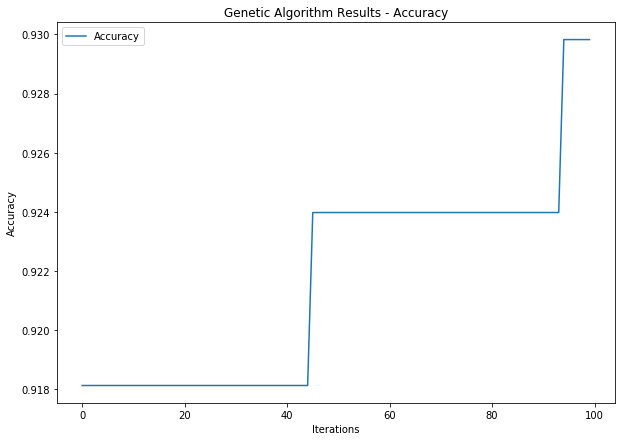

In [30]:
myObj.runGA()